In [ ]:
%cd /content

# download the predictive coding repository
!git clone https://github.com/jgornet/predictive-coding-recovers-maps.git
%cd predictive-coding-recovers-maps/notebooks
!pip install -r ../requirements.txt

In [1]:
from predictive_coding.analysis import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/home/jamesgornet/miniconda3/envs/malmo/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/jamesgornet/Documents/navigation/predictive-coding-recovers-maps/notebooks/predictive_coding/trainer.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Predictive coding

In this Google Colab notebook, we apply a pre-trained predictive coding neural network to a dataset containing observations from an agent navigating the Minecraft environment. First, we load the predictive coding neural network. Next, we import the validation dataset that captures episodes of an agent moving through various terrains in Minecraft. Our goal is to utilize the network's attention-based decoder to generate latent vectors from the data. These vectors provide a condensed representation of the agent's interactions within the environment.


To quantify the positional data inherent in the predictive coder, we employ a neural network designed to predict the agent's position based on these latent units. The prediction error of the neural network, defined as $𝐸(x,\hat{x}) = \Vert \hat{x}−x \Vert_{\ell_2}$, serves as an indirect metric for gauging the positional information retained by the predictive coder.

For a comprehensive assessment, we introduce a position prediction models to set a lower bound on the prediction error. The model incorporates the agent's true position with a slight Gaussian noise $\hat{x} = x + 𝜖, 𝜖 ∼ 𝒩(0,𝜎)$. To draw a contrast, the predictive coder's prediction errors are juxtaposed with these baseline models using histograms.

Results highlight the proficiency of the predictive coder in encoding spatial positions. A noteworthy mention is its mean error of 5.04 lattice units and that over 80% of its samples deviate by less than 7.3 lattice units. Comparatively, the Gaussian noise model (with \(𝜎 = 4\)) has a slightly better mean error of 4.98 lattice units, and its samples mostly have an error below 7.12 lattice units. However, the shuffle model drastically underperforms with an average error of 15.87 lattice units and most samples exceeding an error of 22.24 lattice units.


In [2]:
latents = np.load('../weights/predictive-coder-environment-latents.npy')
positions = np.load('../weights/predictive-coder-environment-positions.npy')[:, :2]

In [3]:
latents = Latents(latents, positions)

In [4]:
position_decoder = PositionDecoder()
position_decoder.train(latents)

  0%|          | 0/8000 [00:00<?, ?it/s]

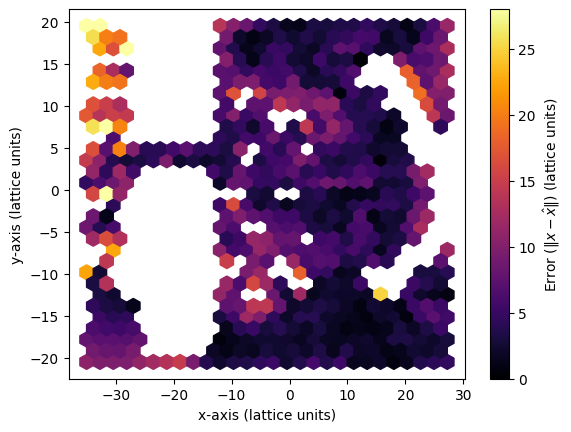

In [5]:
error_map(position_decoder, latents)
plt.show()

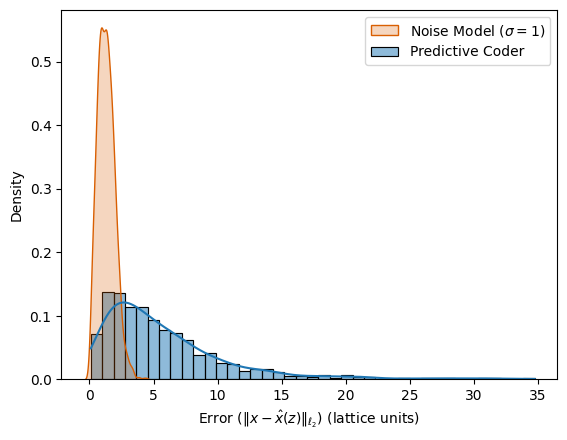

In [6]:
error = position_decoder.error(latents)
noise = np.linalg.norm(np.random.randn(len(error), 2), axis=1)
error_histogram(
    [error], 
    ["Predictive Coder"], 
    [plt.cm.tab10(0)]
)
sns.kdeplot(noise, fill=True, label="Noise Model ($\sigma=1$)", color=plt.cm.Dark2(1))
plt.legend()
plt.show()

In [8]:
latents = np.load('../weights/predictive-coder-path-latents.npy')
positions = np.load('../weights/predictive-coder-path-positions.npy')[:, :2]
latents = Latents(latents, positions)


In [9]:
regression = LogRegression(1, 1, latents, "Predictive Coding", plt.cm.tab10(0))
regression.train(latents)

Exploring further, we discern that the latent space of the predictive coder effectively captures the local distances between physical positions in the environment. By examining every agent's path, we compute local pairwise distances both in real space and within the coder's latent space considering a window of 100 time points.  An intriguing observation is the correlation between latent space distances and actual physical distances, which can be modeled with the equation \(𝑑(𝑧,𝑧′) = 𝛼 log(∥𝑥−𝑥′+𝜖∥)+𝛽, 𝜖 ∼ 𝒩(0,𝜎)\).

Lastly, as a control measure, we reshuffle the physical positions and compute latent distances based on this shuffled set. Our model's distribution aligns closely with the predictive coder's distribution, boasting a Kullback-Leibler divergence (DKL) of just 0.429 bits. In contrast, the shuffled or null distribution diverges significantly from the coder's distribution, displaying a DKL value of 2.441 bits.


/home/jamesgornet/Documents/navigation/predictive-coding-recovers-maps/notebooks/predictive_coding/analysis.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


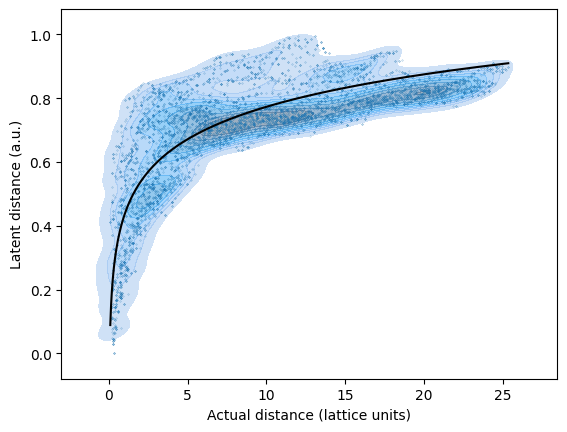

In [10]:
distribution_plot([regression])
plt.show()

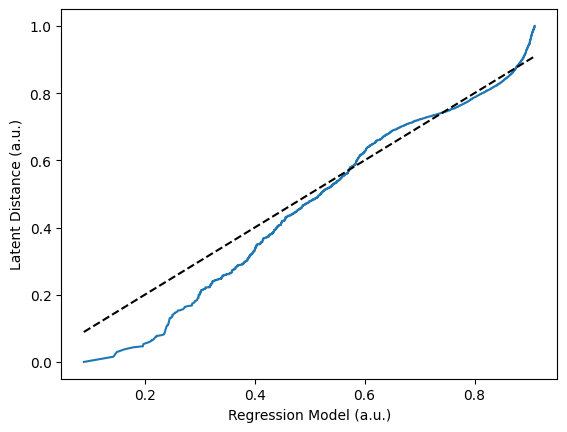

In [11]:
qq_plot([regression])
plt.show()

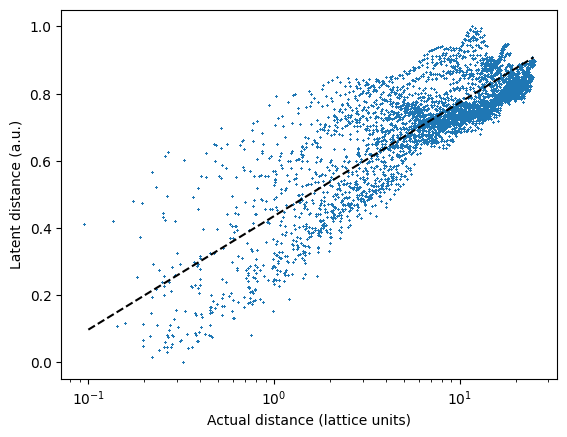

In [12]:
regression_plot([regression])
plt.show()